In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
zfile = ZipFile('/content/drive/MyDrive/test/Teeth DataSet.zip')
zfile.extractall('data')

In [121]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, ReLU, Input, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50, InceptionV3, InceptionResNetV2, MobileNetV2
from keras.models import Sequential, Model
from keras import layers, models
from keras.preprocessing.image import load_img
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import shutil

In [ ]:
import shutil

shutil.move('/content/data/Teeth_Dataset/Testing/out', '/content')
shutil.move('/content/data/Teeth_Dataset/Testing/output', '/content')
shutil.move('/content/data/Teeth_Dataset/Testing/outputs', '/content')

# Data Preprocessing

In [8]:
train_gen = ImageDataGenerator(rescale=1/255,
                               horizontal_flip=True,
                               zoom_range=0.3,
                               rotation_range=0.3)

test_gen = ImageDataGenerator(rescale=1/255)

In [9]:
train_data = train_gen.flow_from_directory('/content/data/Teeth_Dataset/Training',
                                           class_mode='categorical',
                                           target_size=(224, 224),
                                           batch_size=32)

test_data = test_gen.flow_from_directory('/content/data/Teeth_Dataset/Testing',
                                            class_mode='categorical',
                                           target_size=(224, 224),
                                           batch_size=32)
val_data = test_gen.flow_from_directory('/content/data/Teeth_Dataset/Validation',
                                            class_mode='categorical',
                                           target_size=(224, 224),
                                           batch_size=32)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [83]:
test_data.class_indices

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

# Build the model

In [ ]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False

base_model.summary()

In [14]:
last_layer_in_base_model = base_model.get_layer('out_relu')

In [19]:
def build_model(base_model, last_layer):
  input = base_model.input
  model_output = base_model.output

  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(model_output)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
  x = GlobalAveragePooling2D()(x)

  x = Flatten()(x)
  x = Dense(1028, activation='relu')(x)
  x = Dense(7, activation='softmax')(x)

  return Model(inputs=input, outputs=x)

In [20]:
model = build_model(base_model, last_layer_in_base_model)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'mae'])

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 13,410,919 (51.16 MB)

 Trainable params: 11,152,935 (42.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
hist = model.fit(train_data, epochs=50, batch_size=32, validation_data=val_data)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 473ms/step - accuracy: 0.2303 - loss: 3.1855 - mae: 0.2313 - val_accuracy: 0.4076 - val_loss: 1.4504 - val_mae: 0.1979
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 386ms/step - accuracy: 0.4062 - loss: 1.3994 - mae: 0.1919 - val_accuracy: 0.4523 - val_loss: 1.2524 - val_mae: 0.1820
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.4947 - loss: 1.2322 - mae: 0.1755 - val_accuracy: 0.4893 - val_loss: 1.1283 - val_mae: 0.1650
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 392ms/step - accuracy: 0.5131 - loss: 1.1602 - mae: 0.1659 - val_accuracy: 0.5632 - val_loss: 1.0692 - val_mae: 0.1477
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 377ms/step - accuracy: 0.5523 - loss: 1.0535 - mae: 0.1530 - val_accuracy: 0.5350 - val_loss: 1.0898 - val_mae: 0.1567
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 370ms/step - accuracy: 0.6282 - loss: 0.9350 - mae: 0.1386 - val_accuracy: 0.6255 - val_loss: 0.9776 - val_mae: 0.1363
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━

# Model visualization

In [82]:
eval = model.evaluate(test_data)
print(f'Test Loss: {eval[0]* 100 :.2f} %')
print(f'Test Accuracy: {eval[1]* 100 :.2f} %')

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9549 - loss: 0.1369 - mae: 0.0171
Test Loss: 13.02 %
Test Accuracy: 95.82 %


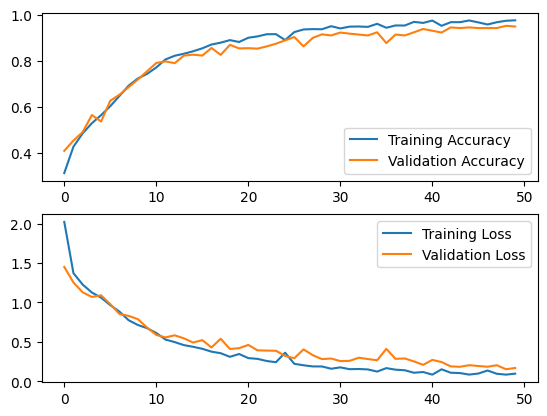

In [52]:
# visualize results
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')

plt.show()

In [34]:
def generate_activation_map(model, image, layer_name, size):
  layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  activations = layer_model.predict(image)
  activations = cv2.resize(activations[0, :, :, 0], size)
  return activations

In [77]:
# Class Activation Map
input_image = tf.keras.preprocessing.image.load_img('/content/data/Teeth_Dataset/Testing/Gum/g_1209_0_8925.jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(input_image)
img_array = np.expand_dims(img_array, axis=0) / 255.

cam = generate_activation_map(model, img_array, 'out_relu', (224, 224))
cam = cv2.resize(cam, (224, 224))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


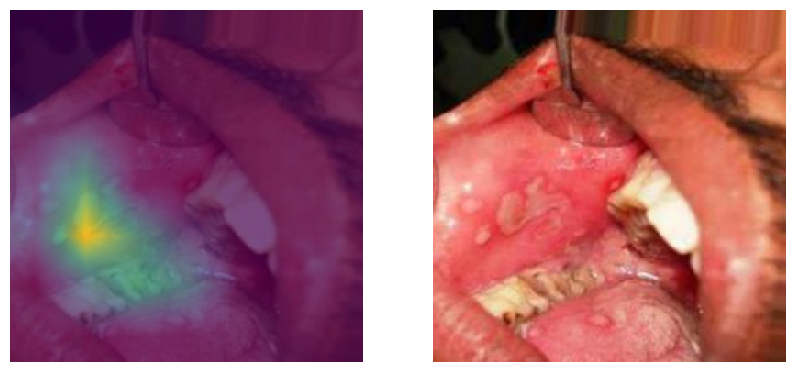

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(input_image)
ax[0].imshow(cam, alpha=0.7)
ax[0].axis('off')

ax[1].imshow(input_image)
ax[1].axis('off')
plt.show()

In [84]:
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0) / 255.
    return image

# Function to generate the saliency map
def generate_saliency_map(model, input_image):
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        top_class = tf.argmax(predictions[0])
        top_class_output = predictions[:, top_class]

    gradients = tape.gradient(top_class_output, input_image)

    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    return saliency_map

# Saliency Map

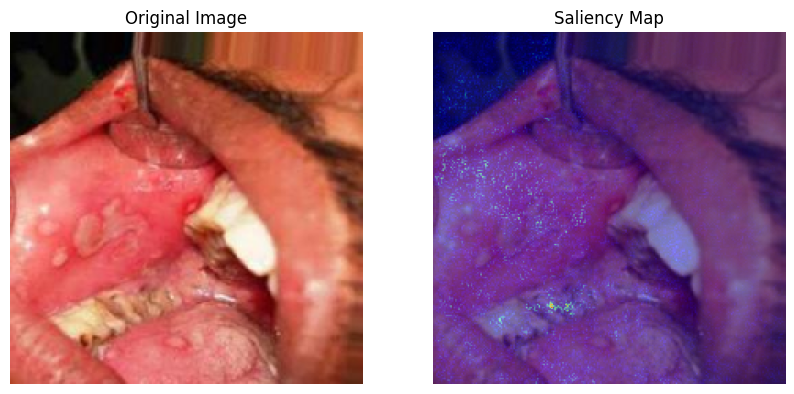

In [97]:
def visualize_saliency_map(saliency_map, original_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.imshow(saliency_map, alpha=0.5, cmap='jet')
    plt.axis('off')
    plt.title('Saliency Map')

    plt.show()

image_path = '/content/data/Teeth_Dataset/Testing/Gum/g_1209_0_8925.jpg'
original_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
input_image = preprocess_image(image_path)

saliency_map = generate_saliency_map(model, input_image)
visualize_saliency_map(saliency_map, original_image)

# Combine ML with the Model

In [114]:
encoder_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)

In [116]:
pred = encoder_model.predict(input_image)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


(1, 7, 7, 512)

In [113]:
os.mkdir('encoded_images')

In [119]:
classes = {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [ ]:
x = []
y = []

for folder in os.listdir('/content/data/Teeth_Dataset/Training'):
  for image in os.listdir(f'/content/data/Teeth_Dataset/Training/{folder}'):
    # img = load_img(, target_size=(224, 224))
    img = preprocess_image(f'/content/data/Teeth_Dataset/Training/{folder}/{image}')

    pred = encoder_model.predict(img, verbos=False)
    x.append(pred.flatten())
    y.append(classes[folder])
x = np.array(x)
y = np.array(y)

In [140]:
np.save('x.npy', x)
np.save('y.npy', y)

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [135]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(x_train, y_train)

SVC(kernel='linear')

In [137]:
score = svm_classifier.score(x_test, y_test)
print(f'SVM Classifier Accuracy: {score * 100:.2f}%')

SVM Classifier Accuracy: 90.13%
